# Federated Learning: Credit Card Fraud Detection

This notebook demonstrates a complete federated learning implementation for credit card fraud detection using PyTorch and Flower.

## Objectives

1. Understand the credit fraud detection problem
2. Build a PyTorch neural network for fraud detection
3. Implement federated learning with multiple clients
4. Compare IID vs Non-IID data distributions
5. Evaluate model performance
6. Understand privacy benefits

## Setup

Import necessary libraries and modules:

In [12]:
import sys
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import FraudDetectionModel, train_model, evaluate_model
from data_loader import (
    create_synthetic_data,
    split_data_federated,
    get_dataloader,
    get_class_weights,
    print_data_statistics
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Libraries imported successfully!
PyTorch version: 2.5.1+cu121
Device: cuda


## 1. Problem Overview: Credit Card Fraud Detection

### The Challenge

Credit card fraud is a significant problem:
- **Billions in losses** annually
- **Privacy-sensitive** data (financial transactions)
- **Class imbalance**: Frauds are rare (~0.2% of transactions)
- **Distributed data**: Different banks hold different transaction data

### Why Federated Learning?

Traditional approach: Banks share data → Privacy risk, regulatory issues

Federated approach:
-  **Banks keep data locally**
- **Only model updates are shared**
-  **Comply with regulations (GDPR, PCI-DSS)**
- **Benefit from collective knowledge**

## 2. Data Preparation

### Create Synthetic Credit Card Data

For this demonstration, we'll create synthetic data that mimics real credit card transactions:

In [13]:
# Create synthetic data
print("Creating synthetic credit card transaction data...")
X, y = create_synthetic_data(
    n_samples=10000,
    n_features=30,  # Time, V1-V28, Amount
    fraud_ratio=0.002  # 0.2% fraud rate
)

print(f"\nDataset created:")
print(f"  Total samples: {len(X):,}")
print(f"  Features: {X.shape[1]}")
print(f"  Legitimate: {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.2f}%)")
print(f"  Fraudulent: {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.2f}%)")

Creating synthetic credit card transaction data...

Dataset created:
  Total samples: 10,000
  Features: 30
  Legitimate: 9,980 (99.80%)
  Fraudulent: 20 (0.20%)


### Visualize Class Distribution

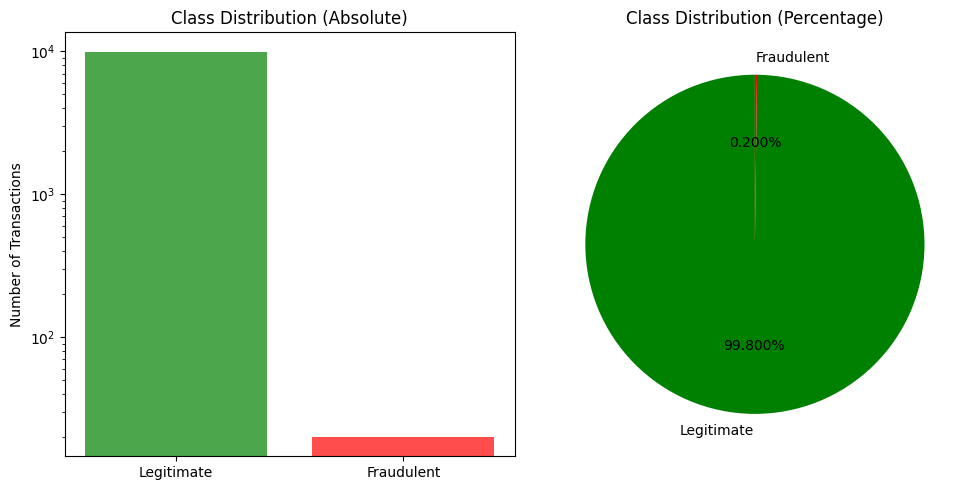

Note: Severe class imbalance - this is realistic for fraud detection!


In [14]:
# Plot class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
labels = ['Legitimate', 'Fraudulent']
counts = [np.sum(y == 0), np.sum(y == 1)]
colors = ['green', 'red']
plt.bar(labels, counts, color=colors, alpha=0.7)
plt.ylabel('Number of Transactions')
plt.title('Class Distribution (Absolute)')
plt.yscale('log')  # Log scale to see both classes

plt.subplot(1, 2, 2)
plt.pie(counts, labels=labels, colors=colors, autopct='%1.3f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("Note: Severe class imbalance - this is realistic for fraud detection!")

## 3. Federated Data Split

Simulate 3 banks (clients) with different data distributions:

In [15]:
# Split data among clients
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# First, split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train/Test split:")
print(f"  Training: {len(X_train):,} samples")
print(f"  Testing: {len(X_test):,} samples")

Train/Test split:
  Training: 8,000 samples
  Testing: 2,000 samples


### IID Split: Each bank has similar data distribution

In [16]:
# Create IID split
print("\n" + "="*60)
print("IID Data Split (Independent and Identically Distributed)")
print("="*60)

client_data_iid = split_data_federated(
    X_train, y_train,
    num_clients=3,
    iid=True
)

print_data_statistics(client_data_iid)


IID Data Split (Independent and Identically Distributed)

Federated Data Distribution

Client 0:
  Total samples: 2,667
  Legitimate: 2,658 (99.66%)
  Fraudulent: 9 (0.34%)

Client 1:
  Total samples: 2,667
  Legitimate: 2,663 (99.85%)
  Fraudulent: 4 (0.15%)

Client 2:
  Total samples: 2,666
  Legitimate: 2,663 (99.89%)
  Fraudulent: 3 (0.11%)



### Non-IID Split: Each bank has different data distribution

In [17]:
# Create Non-IID split
print("\n" + "="*60)
print("Non-IID Data Split (Different Distributions)")
print("="*60)

client_data_non_iid = split_data_federated(
    X_train, y_train,
    num_clients=3,
    iid=False
)

print_data_statistics(client_data_non_iid)


Non-IID Data Split (Different Distributions)

Federated Data Distribution

Client 0:
  Total samples: 2,666
  Legitimate: 2,666 (100.00%)
  Fraudulent: 0 (0.00%)

Client 1:
  Total samples: 2,666
  Legitimate: 2,666 (100.00%)
  Fraudulent: 0 (0.00%)

Client 2:
  Total samples: 2,666
  Legitimate: 2,652 (99.47%)
  Fraudulent: 14 (0.53%)



## 4. Model Architecture

Define the neural network for fraud detection:

In [18]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FraudDetectionModel(
    input_dim=30,
    hidden_dims=[64, 32, 16],
    dropout_rate=0.3
).to(device)

print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Model Architecture:
FraudDetectionModel(
  (network): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)

Model Statistics:
  Total parameters: 4,850
  Trainable parameters: 4,850


## 5. Simulated Federated Training

Simulate federated learning with 3 clients:

In [19]:
import torch.nn as nn
import torch.optim as optim

def simulate_federated_round(client_data, global_model, device, local_epochs=5):
    """
    Simulate one round of federated learning.
    
    Returns:
        Updated global model and metrics
    """
    client_updates = []
    client_sizes = []
    
    # Each client trains locally
    for client_id, (X_client, y_client) in enumerate(client_data):
        # Create client model (copy of global model)
        client_model = FraudDetectionModel(
            input_dim=30,
            hidden_dims=[64, 32, 16],
            dropout_rate=0.3
        ).to(device)
        
        # Copy global model weights
        client_model.load_state_dict(global_model.state_dict())
        
        # Prepare data
        train_loader = get_dataloader(X_client, y_client, batch_size=32, use_sampler=True)
        class_weights = get_class_weights(y_client).to(device)
        
        # Train locally
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(client_model.parameters(), lr=0.001)
        
        train_loss, train_acc = train_model(
            client_model, train_loader, criterion, optimizer, device, epochs=local_epochs
        )
        
        print(f"  Client {client_id}: Loss={train_loss:.4f}, Accuracy={train_acc:.4f}")
        
        # Collect update
        client_updates.append(client_model.state_dict())
        client_sizes.append(len(X_client))
    
    # Aggregate updates (FedAvg)
    total_size = sum(client_sizes)
    aggregated_state = {}
    
    for key in client_updates[0].keys():
        aggregated_state[key] = sum(
            (size / total_size) * client_updates[i][key]
            for i, size in enumerate(client_sizes)
        )
    
    # Update global model
    global_model.load_state_dict(aggregated_state)
    
    return global_model

print("Federated learning simulation function defined!")

Federated learning simulation function defined!


### Run Federated Training

In [20]:
# Initialize global model
global_model = FraudDetectionModel(
    input_dim=30,
    hidden_dims=[64, 32, 16],
    dropout_rate=0.3
).to(device)

# Training parameters
num_rounds = 5
local_epochs = 5

print("="*60)
print("Starting Federated Training")
print("="*60)
print(f"Rounds: {num_rounds}")
print(f"Local epochs per round: {local_epochs}")
print(f"Clients: {len(client_data_iid)}")
print("="*60 + "\n")

# Track metrics
round_metrics = []

# Run federated learning
for round_num in range(1, num_rounds + 1):
    print(f"\nRound {round_num}/{num_rounds}:")
    
    # Simulate federated round
    global_model = simulate_federated_round(
        client_data_iid,
        global_model,
        device,
        local_epochs=local_epochs
    )
    
    # Evaluate global model
    test_loader = get_dataloader(X_test, y_test, batch_size=32, shuffle=False)
    class_weights = get_class_weights(y_test).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    loss, acc, prec, rec, f1 = evaluate_model(
        global_model, test_loader, criterion, device
    )
    
    print(f"\n  Global Model Evaluation:")
    print(f"    Loss: {loss:.4f}")
    print(f"    Accuracy: {acc:.4f}")
    print(f"    Precision: {prec:.4f}")
    print(f"    Recall: {rec:.4f}")
    print(f"    F1-Score: {f1:.4f}")
    
    round_metrics.append({
        'round': round_num,
        'loss': loss,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

print("\n" + "="*60)
print("Federated Training Completed!")
print("="*60)

Starting Federated Training
Rounds: 5
Local epochs per round: 5
Clients: 3


Round 1/5:
  Client 0: Loss=0.1407, Accuracy=0.8970
  Client 1: Loss=0.1088, Accuracy=0.9522
  Client 2: Loss=0.1198, Accuracy=0.9167

  Global Model Evaluation:
    Loss: 0.5605
    Accuracy: 0.8955
    Precision: 0.0188
    Recall: 1.0000
    F1-Score: 0.0369

Round 2/5:
  Client 0: Loss=0.0087, Accuracy=0.8523
  Client 1: Loss=0.0037, Accuracy=0.9222
  Client 2: Loss=0.0034, Accuracy=0.8950

  Global Model Evaluation:
    Loss: 0.2279
    Accuracy: 0.9960
    Precision: 0.3333
    Recall: 1.0000
    F1-Score: 0.5000

Round 3/5:
  Client 0: Loss=0.0025, Accuracy=0.9349
  Client 1: Loss=0.0006, Accuracy=0.9737
  Client 2: Loss=0.0005, Accuracy=0.9688

  Global Model Evaluation:
    Loss: 0.0372
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000

Round 4/5:
  Client 0: Loss=0.0017, Accuracy=0.9624
  Client 1: Loss=0.0002, Accuracy=0.9903
  Client 2: Loss=0.0002, Accuracy=0.9823


## 6. Visualize Training Progress

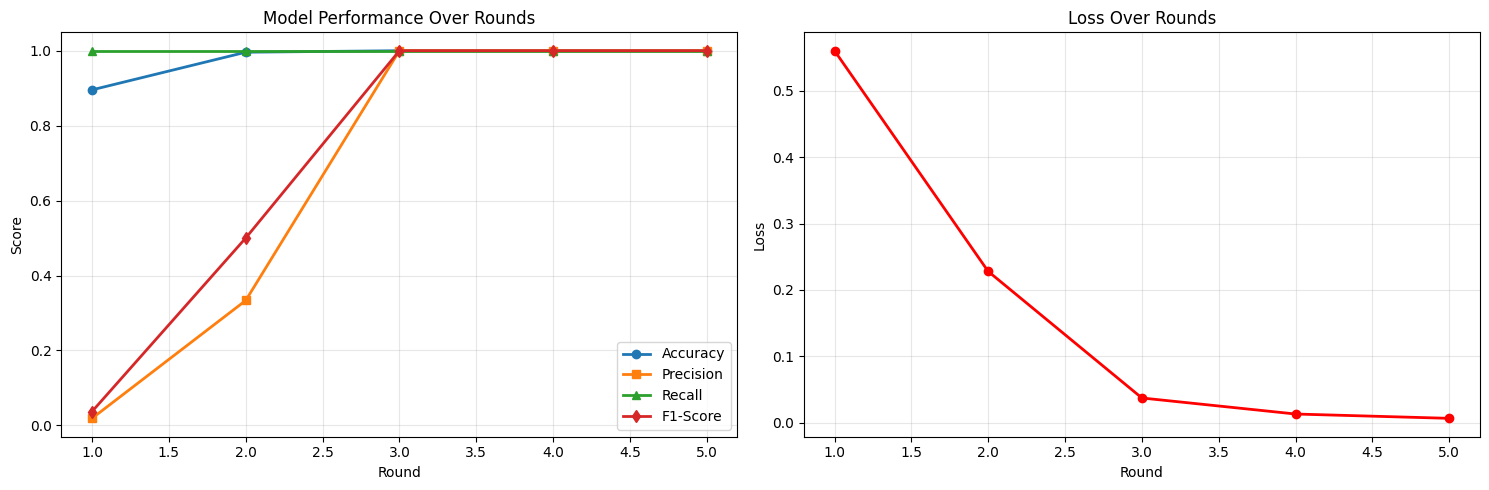

Training completed successfully!

Final Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000


In [21]:
# Plot metrics over rounds
rounds = [m['round'] for m in round_metrics]
accuracy = [m['accuracy'] for m in round_metrics]
precision = [m['precision'] for m in round_metrics]
recall = [m['recall'] for m in round_metrics]
f1_score = [m['f1_score'] for m in round_metrics]
loss = [m['loss'] for m in round_metrics]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot metrics
axes[0].plot(rounds, accuracy, 'o-', label='Accuracy', linewidth=2)
axes[0].plot(rounds, precision, 's-', label='Precision', linewidth=2)
axes[0].plot(rounds, recall, '^-', label='Recall', linewidth=2)
axes[0].plot(rounds, f1_score, 'd-', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Round')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Over Rounds')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(rounds, loss, 'o-', color='red', linewidth=2)
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Over Rounds')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training completed successfully!")
print(f"\nFinal Performance:")
print(f"  Accuracy: {accuracy[-1]:.4f}")
print(f"  Precision: {precision[-1]:.4f}")
print(f"  Recall: {recall[-1]:.4f}")
print(f"  F1-Score: {f1_score[-1]:.4f}")

## 7. Key Insights

### What Happened?

1. **Privacy Preserved**: 
   - Each bank's transaction data stayed local
   - Only model weights were shared
   - No raw transaction data was exchanged

2. **Collaborative Learning**:
   - Global model learned from all three banks
   - Each bank benefited from others' data patterns
   - Model improved over communication rounds

3. **Handling Imbalance**:
   - Used weighted loss function
   - Focused on precision/recall for fraud class
   - F1-score as balanced metric

### Why Federated Learning?

**Traditional ML**:  Share all data → Privacy risk

**Federated Learning**: 
- Data remains with each bank
- Complies with regulations (GDPR, PCI-DSS)
- Maintains competitive advantage
- Still achieves collaborative learning

## 8. Real-World Deployment

To use this in production:

```bash
# Start the server (at central location)
python src/server.py --num-rounds 20 --min-clients 3

# Each bank starts their client
# Bank 1:
python src/client.py --client-id 0 --server-address <server-ip>:8080

# Bank 2:
python src/client.py --client-id 1 --server-address <server-ip>:8080

# Bank 3:
python src/client.py --client-id 2 --server-address <server-ip>:8080
```

### Additional Considerations:

1. **Security**: Use TLS/SSL for communication
2. **Privacy**: Add differential privacy for stronger guarantees
3. **Robustness**: Handle client failures and network issues
4. **Scalability**: Use Flower's deployment features

## Summary

### What We Learned:

1.  **Credit fraud detection** is ideal for federated learning
2.  **Privacy-preserving**: Data never leaves local clients
3.  **Collaborative**: Multiple parties benefit together
4.  **Practical**: Handle real-world challenges (imbalance, non-IID)
5.  **Scalable**: From simulation to production

### Next Steps:

1. Try with real credit card dataset from Kaggle
2. Experiment with different model architectures
3. Test Non-IID scenarios
4. Add differential privacy
5. Deploy to real distributed systems

### Resources:

- [Flower Documentation](https://flower.dev/docs/)
- [Credit Card Fraud Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- [Federated Learning Paper](https://arxiv.org/abs/1602.05629)
- [Repository Documentation](../README.md)